### Imports 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from operator import attrgetter
import sklearn
from sklearn.decomposition import TruncatedSVD
import numpy as np

In [2]:
#Reading the main dataset 
data_main = pd.read_csv("data.csv" ,encoding= 'unicode_escape',parse_dates=['InvoiceDate'], infer_datetime_format=True)
df=pd.read_csv("data.csv" ,encoding= 'unicode_escape',parse_dates=['InvoiceDate'], infer_datetime_format=True)

## Task 1 : Data cleaning and EDA 

Subtask 1 : 
1. Find data types 
2. Find the shape
3. Find the Null values 
4. Find Unique values for Country 
5. Clean Desc column 
6. Remove Duplicates 

In [3]:
#Basic features of the dataset : 
data_main.head(5)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [15]:
data_main.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [16]:
data_main.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

Here, we can see that there are 1454 items with description as Null. Since the dataset is over 5,00,000 lines long, we can let go of 1454 lines without no considerable loss of data. For the data items without CustomerID, we can still use the other columns for analysis hence for now we will not tamper with those columns. 

In [3]:
data_main = data_main.dropna(subset=['Description'])

In [4]:
data_main.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     133626
Country             0
dtype: int64

In [5]:
data_main['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'lost',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

Since we will be using a lot of description based segmentation for our classification, we need to make sure this space is as clean as possible, even if it means loss of data. Hence we will go ahead and see the garbage values and drop them in the following parts of this code. 

In [6]:
data_main[data_main['Description'].map(len) < 9]['Description'].unique()

array(['POSTAGE', 'Discount', 'CARRIAGE', 'Manual', 'amazon', '?',
       'check', 'damages', 'SAMPLES', 'faulty', 'Found', 'found',
       'counted', 'Dotcom', 'showroom', 'MIA', 'broken', '?lost',
       'damages?', 'cracked', 'Damaged', 'damaged', 'DAMAGED', 'Display',
       'Missing', 'returned', 'adjust', 'crushed', 'samples', 'mailout ',
       'mailout', 'smashed', 'missing', 'FOUND', 'dotcom', 'FBA', 'ebay',
       '?missing', 'Crushed', 'test', '??', 'Amazon', 'Dagamed', 'mouldy',
       '20713', 'Damages', 'CHECK', 'missing?', '???lost', 'check?',
       'AMAZON', 'wet?', 'lost??', '???', 'wet', 'mixed up', 'lost'],
      dtype=object)

Here is a list of most of the garabge values and there is no useful data in these. However, to preserve the integrity of the dataset for furthur analysis, we will subset this data into a new dataframe. 

In [7]:
cleaned_desc=data_main.drop(data_main[data_main['Description'].map(len) < 9].index,)

In [8]:
cleaned_desc['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., '????damages????',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [9]:
cleaned_desc = cleaned_desc.drop(cleaned_desc[cleaned_desc['Description'].str.startswith('?')].index)

In [10]:
cleaned_desc['Description'].unique()

array(['WHITE HANGING HEART T-LIGHT HOLDER', 'WHITE METAL LANTERN',
       'CREAM CUPID HEARTS COAT HANGER', ..., 'wet boxes',
       'CREAM HANGING HEART T-LIGHT HOLDER',
       'PAPER CRAFT , LITTLE BIRDIE'], dtype=object)

In [11]:
cleaned_desc['Country'].unique()

array(['United Kingdom', 'France', 'Australia', 'Netherlands', 'Germany',
       'Norway', 'EIRE', 'Switzerland', 'Spain', 'Poland', 'Portugal',
       'Italy', 'Belgium', 'Lithuania', 'Japan', 'Iceland',
       'Channel Islands', 'Denmark', 'Cyprus', 'Sweden', 'Austria',
       'Israel', 'Finland', 'Bahrain', 'Greece', 'Hong Kong', 'Singapore',
       'Lebanon', 'United Arab Emirates', 'Saudi Arabia',
       'Czech Republic', 'Canada', 'Unspecified', 'Brazil', 'USA',
       'European Community', 'Malta', 'RSA'], dtype=object)

We will be needing country values for some analysis and here there are no unknown values so we can proceed with that. 

Lastely, we will be dropping duplicates so as to not corrupt our recommender system. 

In [12]:
cleaned_desc = cleaned_desc.drop_duplicates()

##### Summary  
We cleaned the description column as we will need it for the recommender system in task3. 
Later on, we will also be cleaning the CustomerId column but since it has a lot of null values which cant be treated at the moment, it is not advisable to drop them pre data visulisation. 

## Task 2 : Data Visualization 

Subtasks : 
1. Find the number of repeat customers and number of first time customers 
2. Find YOY growth for each country 
3. Find Sales of each country year wise
4. Identify customer segments or personas based on purchasing patterns, and how do these segments differ in terms of their purchasing behavior
5. Which products had the most cancellations and their descriptions
6. Segment the customers based on scores

### 1. Number of Repeat Customers

To find the number of repeat customers, we first need to find those customers which have made atleast one purchase.
After that we find those who have made 2 or more purchases by checking if there are more than one entires for said customer ID. 
We display this information in a pie for easy inferencing. 

In [13]:
df_clean = df[df['Quantity'] >= 0]
dick=df_clean.groupby(['Country']).nunique()

In [14]:
unique_cust_count=df_clean['CustomerID'].value_counts().to_dict()

In [15]:
repeat=[]
first_time = []
for key, value in unique_cust_count.items():
    if value<2:
        first_time.append(key)
    else:
        repeat.append(key)


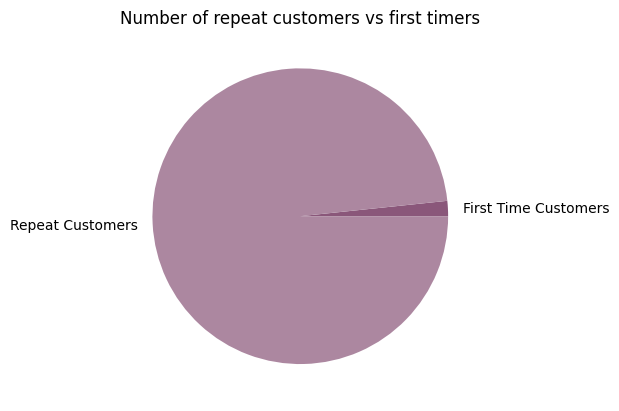

In [148]:
mylabels=["First Time Customers","Repeat Customers"]
plt.title("Number of repeat customers vs first timers")
number_of_customers = plt.pie([len(first_time),len(repeat)],labels = mylabels,colors = ['#8A577A', '#AC87A0'])

**From this plot we can see that > 95% of customers have made multiple purchases and hence the customer retention rate of the company is good.**

## 2. Retention rate country wise : 

This calculation requires creation of new variables such as the Year column. We extract the year from the current invoice date and save it in a new row. Then we find the number of unique Customer IDs for each year and group them by country. There are some countires for which data wasnt present for 2010 and we have ignored said countries. 

In [17]:
#Data engineeering : 
df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
df_clean['Year'] = df_clean['InvoiceDate'].dt.year

df2010=df_clean[df_clean['Year'] == 2010]
final2010=[]
df2010group=df2010.groupby(['Country'])['CustomerID'].nunique()
list_2010 = df2010group.tolist() #List of values 

df2010list=df2010group.axes #List of countries

for i in range(len(list_2010)):
    final2010.append([df2010list[0][i],list_2010[i]])

df2010list=df2010list[0].tolist()
df2010group=df2010.groupby(['Country'])['CustomerID'].nunique()
df2010list=df2010group.axes
df2010list=df2010list[0].tolist()

df2011=df_clean[df_clean['Year'] == 2011]
final2011=[]
df2011group=df2011.groupby(['Country'])['CustomerID'].nunique()
list_2011 = df2011group.tolist()

df2011list=df2011group.axes

for i in range(len(list_2011)):
    final2011.append([df2011list[0][i],list_2011[i]])
df2011list=df2011list[0].tolist()

df2011list.append('Lithuania')
list_2011.append(0)

#Computing the growth : 

country_list=[]
change_list=[]
for i in range(0,len(df2010list)):
    temp=df2011list.index(df2010list[i])
    country = df2011list[temp]

    val2010 = list_2010[i]
    val2011 = list_2011[temp]
    
    if(val2010==0):
        country_list.append(df2010list[i])
        change_list.append(0)
    else:
        change = (val2011-val2010)/val2010
        country_list.append(df2010list[i])
        change_list.append(change)


/var/folders/mr/kssk23v57tb4236qqsb_hp1m0000gp/T/ipykernel_73718/284174564.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['InvoiceDate'] = pd.to_datetime(df_clean['InvoiceDate'])
/var/folders/mr/kssk23v57tb4236qqsb_hp1m0000gp/T/ipykernel_73718/284174564.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Year'] = df_clean['InvoiceDate'].dt.year


Text(0, 0.5, 'Growth %')

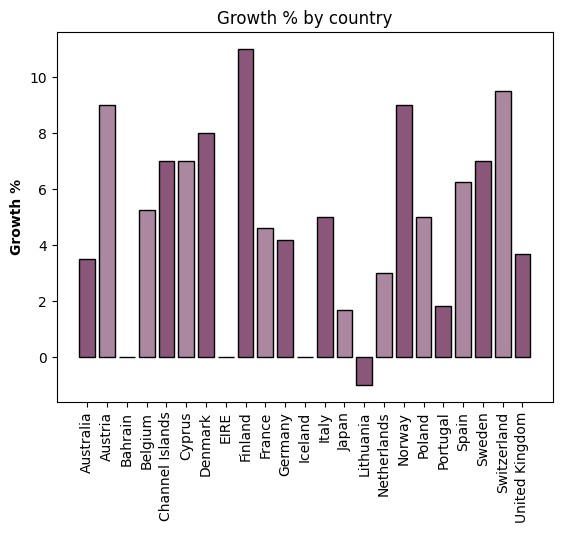

In [147]:
#Plotting the growth rate : 
fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('white')

plt.xticks(ticks=range(len(country_list)), labels=country_list, rotation=90)
growth_rate = plt.bar(country_list,change_list, color=['#8A577A', '#AC87A0'],edgecolor = "black")
plt.title("Growth % by country")
plt.ylabel("Growth %", fontweight='bold')

**We see a healthy growth in most countries except Lithuaina where the number of customers have reduced YoY.

## 3. Sales per country annualised

We need to create seperate columns to realise this task. We create a few more variables like the total order value. Then we group these by country and use sum as the aggregation measure. 
We give the plots as a stacked bar and also seperaly since the scales were so different, the stacked graphs werent understandable. 

In [150]:
#Creating a subset having the reqiuered variables
df_topitems = df[df['Quantity'] >= 0]
df_topitems['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df_topitems['InvoiceDate'] = pd.to_datetime(df_topitems['InvoiceDate'])
df_topitems['Year'] = df_topitems['InvoiceDate'].dt.year

#Creating subsets for 2010 and 2011 and grouping them by country
df_sum_2010 = df_topitems[df_topitems['Year']==2010]
df_sum_2010 =df_sum_2010.groupby(['Country']).sum()

df_sum_2011 = df_topitems[df_topitems['Year']==2011]
df_sum_2011 =df_sum_2011.groupby(['Country']).sum()

#Extracting the list of countries in 2010 and 2011
bar_list2011=df_sum_2011.axes[0].tolist()
bar_list2010=df_sum_2010.axes[0].tolist()

#Extracting the total sales country wise in 2010 and 2011
bar_sales2011 = df_sum_2011['TotalPrice'].tolist()
bar_sales2010 = df_sum_2010['TotalPrice'].tolist()

#Dropping Lithuaina from the 2010 list as it doesnt exist in the 2011 list
bar_list2010.pop(14)
bar_sales2010.pop(14)

#Creating a list which has the sales data from 2010 and dimensions of 2011 lists. Whichever country wasnt recorded in 2010 is assigned 0
final_sales2010=[]
count=0
for i in range(len(bar_list2011)):
    country2011 = bar_list2011[i]
    if(country2011 in bar_list2010):
        final_sales2010.append(bar_sales2010[count])
        count=count+1
    else:
        final_sales2010.append(0)
        
#Dropping United Kingdom for scaling purposes

test2010=bar_list2010.copy()
test2010.pop()
test2010.pop()
val2010=final_sales2010.copy()
val2010.pop()
uk2010=val2010.pop()

test2011=bar_list2011.copy()
test2011.pop()
test2011.pop()
val2011=bar_sales2011.copy()
val2011.pop()
uk2011=val2011.pop()

/var/folders/mr/kssk23v57tb4236qqsb_hp1m0000gp/T/ipykernel_73718/3843838782.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topitems['TotalPrice'] = df['Quantity'] * df['UnitPrice']
/var/folders/mr/kssk23v57tb4236qqsb_hp1m0000gp/T/ipykernel_73718/3843838782.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_topitems['InvoiceDate'] = pd.to_datetime(df_topitems['InvoiceDate'])
/var/folders/mr/kssk23v57tb4236qqsb_hp1m0000gp/T/ipykernel_73718/3843838782.py:5: SettingWithCopyWarning: 
A value is tryin

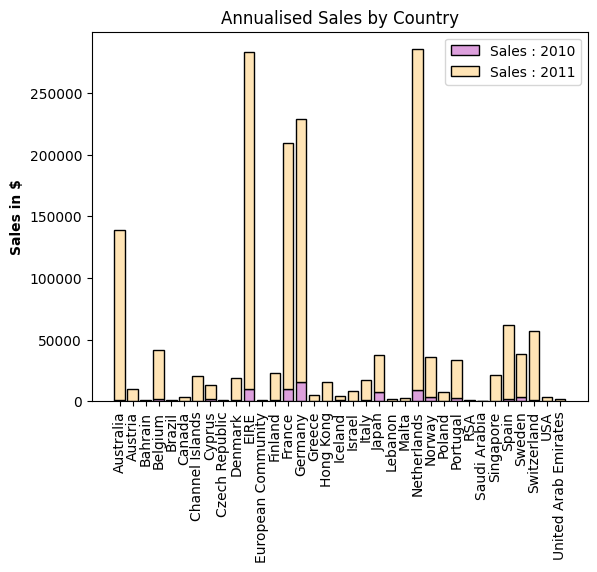

In [151]:
#Plotting the graphs 

fig, ax = plt.subplots(nrows=1, ncols=1)
ax.set_facecolor('white')

plt.title("Annualised Sales by Country")
plt.ylabel("Sales in $", fontweight='bold')

plt.xticks(ticks=range(len(test2011)), labels=test2011, rotation=90)
plt.bar(test2011,val2011)

x1=plt.bar(test2011, val2010, color='plum',edgecolor = "black")
x2=plt.bar(test2011, val2011, bottom=val2010, color='moccasin',edgecolor = "black")

plt.legend([x1, x2], ['Sales : 2010', 'Sales : 2011'])

**We can clearly see that in almost all markets the sales for 2011 were much higher than 2010. This coupled with the average 6% growth rate in customers tells us that each customer has started shopping for more.**

In [168]:
only2010_sales = bar_sales2010.copy()
only2010_sales.pop()
only2010_bar = bar_list2010.copy()
only2010_bar.pop()

'United Kingdom'

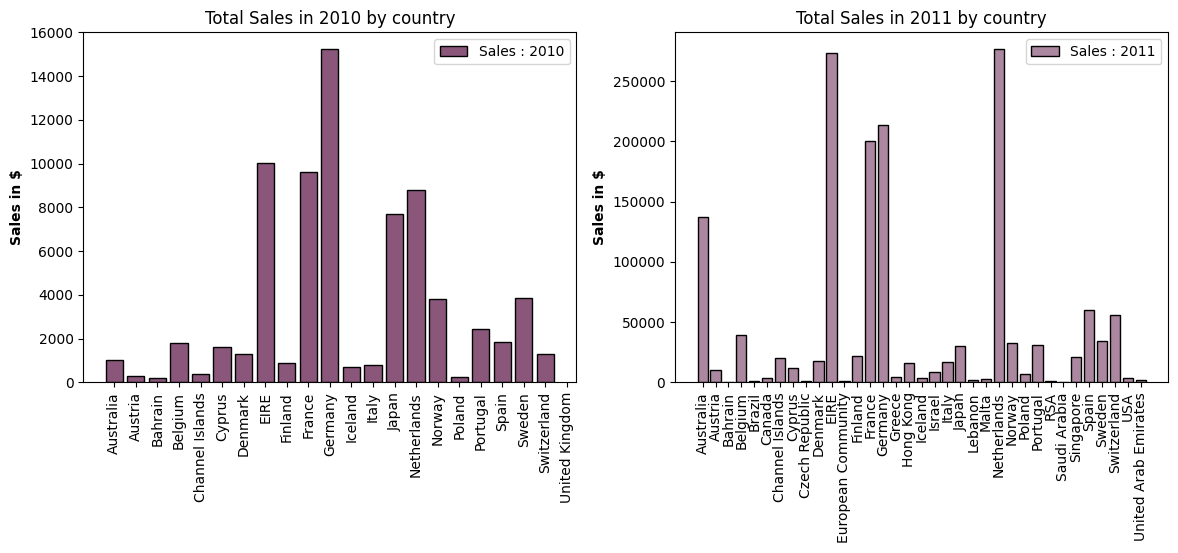

In [170]:
plt.figure(figsize=(14,10))
plt.subplot(2,2,1)
plt.xticks(ticks=range(len(bar_list2010)), labels=bar_list2010, rotation=90)
x1=plt.bar(only2010_bar,only2010_sales,color=['#8A577A'],edgecolor = "black")

plt.title("Total Sales in 2010 by country")
plt.ylabel("Sales in $", fontweight='bold')

plt.legend([x1], ['Sales : 2010'])

plt.subplot(2,2,2)
plt.xticks(ticks=range(len(test2011)), labels=test2011, rotation=90)
x1=plt.bar(test2011,val2011,color=['#AC87A0'],edgecolor = "black")


plt.title("Total Sales in 2011 by country")
plt.ylabel("Sales in $", fontweight='bold')

plt.legend([x1], ['Sales : 2011'])


In the above graphs, the value for United Kingdom has been left out due to scaling issues. Comparision of sales of United Kingdom are given below. 

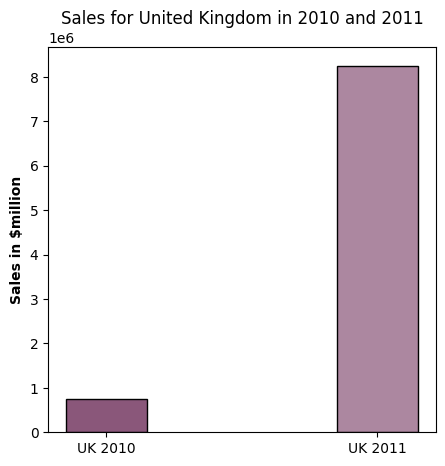

In [171]:
plt.figure(figsize=(5,5)) 
plt.title("Sales for United Kingdom in 2010 and 2011")
plt.ylabel("Sales in $million", fontweight='bold')
x1=plt.bar(["UK 2010","UK 2011"],[uk2010,uk2011],color=['#8A577A', '#AC87A0'],edgecolor = "black",width=0.3)

## 4. Customer Segmentation 

RFM analysis stands for Receny Frequency and Monetary analysis. To realise this, we compute Recency Frequency and Monetary values as follows : 
1. Receny : Find the difference between the latest date of purchase and the date of report (11/12/2011) 
2. Frequency : Find the number of times each CustomerID has occured in the database
3. Monmetary : Find the sum of the amount spent by each user. 
Then we remove those customers whose Monetary score is 0 as they have never made any purchase.

To create buckets of the RFM values ,we first need to get them in the same range.
Hence we have defined 5 sub buckets for each variable, each residing at the 20th %ile , 40th %ile , 60th %ile , 80th %ile and 100th %ile

In [22]:
df['InvoiceDate'].max()
df['TotalPrice'] = df['Quantity']*df['UnitPrice']
today_date = dt.datetime(2011,12,11)

rfm = df.groupby('CustomerID').agg({'InvoiceDate': lambda x: (today_date - x.max()).days,
                                    'InvoiceNo': lambda x: x.nunique(),
                                    'TotalPrice': lambda x: x.sum()})

rfm.columns = ['recency', 'frequency', 'monetary']
#rfm['monetary'] = rfm[rfm['monetary'] > 0]
rfm = rfm.reset_index()

rfm.head() 

#Here, we are assigning certain scores to the customers based on their purchase history.
#We count the recency based on the number of days passed since the last purchase
#We determine the frequency based on the number of unique invoice numbers of the user
#The monetary is the total sums of purchase made by each consumer 

,CustomerID,recency,frequency,monetary
0,12346.0,326,2,0.00
1,12347.0,3,7,4310.00
2,12348.0,76,4,1797.24
3,12349.0,19,1,1757.55
4,12350.0,311,1,334.40


In [24]:
rfm= rfm.drop(rfm[rfm['monetary']<=0].index)

In [25]:
rfm_country=[]
for i in rfm['CustomerID']:
    cust_country=df['Country'][df['CustomerID']==i]
    rfm_country.append(cust_country.tolist()[0])
rfm['Country']=rfm_country

In [80]:
rfm_customers=rfm_stats['CustomerID'].tolist() 
#Put this as the top of the bar to indicate the max spender

In [48]:
rfm.groupby(['Country']).sum()
AOV = pd.DataFrame()
AOV['Country']=rfm.groupby(['Country']).sum().axes[0]
AOV['Frequency'] = list(rfm.groupby(['Country']).sum()['frequency'])
AOV['Monetary'] = list(rfm.groupby(['Country']).sum()['monetary'])
AOV['AOV'] = AOV['Monetary']/AOV['Frequency']

In [72]:
AOV2 = AOV.copy()

In [80]:
AOV= AOV.drop(AOV.loc[AOV['Country'] == "United Kingdom"].index)

In [81]:
AOV.tail(5)

,Country,Frequency,Monetary,AOV
31,Sweden,46,36595.91,795.563261
32,Switzerland,73,55518.39,760.525890
33,USA,5,1730.92,346.184000
34,United Arab Emirates,3,1902.28,634.093333
36,Unspecified,8,2667.07,333.383750


<Figure size 1200x500 with 0 Axes>

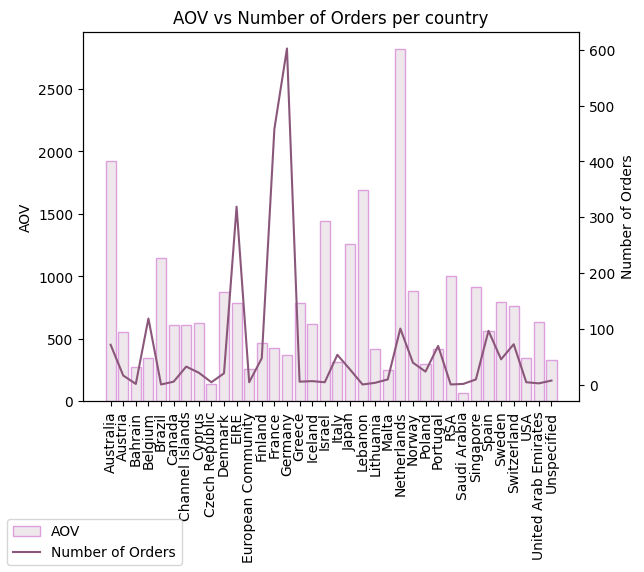

In [179]:
plt.figure(figsize=(12,5)) 

fig, ax1 = plt.subplots()
ax1.bar(AOV['Country'],AOV['AOV'],color=['#EEE7EC'],edgecolor = "plum",label="AOV")
ax1.set_ylabel("AOV")

plt.xticks(ticks=range(len(AOV['Country'])), labels=AOV['Country'], rotation=90)

ax2 = ax1.twinx()
ax2.plot(AOV['Country'],AOV['Frequency'],color="#8A577A",label="Number of Orders")
ax2.set_ylabel('Number of Orders')

plt.title("AOV vs Number of Orders per country")
fig.legend(loc ="lower left")

plt.show()

**In the above chart, we can see that the Number of orders is very high for France as compared to the AOV whereas the inverse is true for Neatherlands, showing us that the people in France spend lower per order but there is volume, so we can attempt to increase minimum order value.**

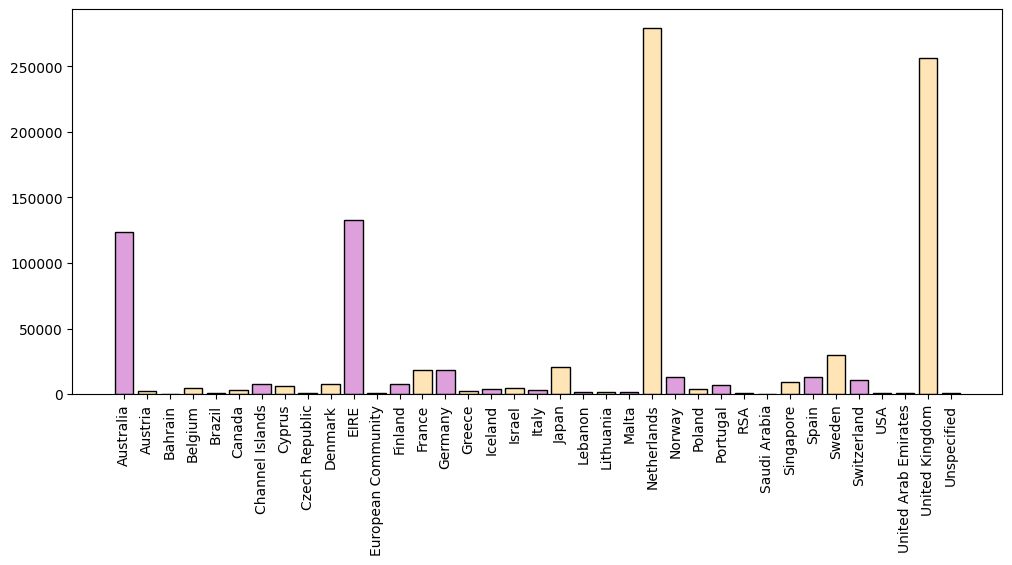

In [27]:
plt.figure(figsize=(12,5)) 
rfm_stats=rfm.groupby(['Country']).max()


plt.xticks(ticks=range(len(rfm_stats.axes[0].tolist())), labels=rfm_stats.axes[0].tolist(), rotation=90)

rfm_stats.sort_values(by='monetary', ascending=False)
x=plt.bar(rfm_stats.axes[0].tolist(),rfm_stats['monetary'],color=['plum', 'moccasin'],edgecolor = "black")


**This shows us the single highest spender per country and we can see that one of the customers in Australia EIRE Neatherlands and the UK is spending a lot on our platform.**

In [100]:
def get_rfm_scores(dataframe) -> pd.core.frame.DataFrame:
    df_ = dataframe.copy()
    df_["recency_score"] = pd.qcut(df_["recency"], 5, labels=[5, 4, 3, 2, 1])
    df_["frequency_score"] = pd.qcut(df_["frequency"].rank(method="first"), 5, labels=[1, 2, 3, 4, 5])
    df_["monetary_score"] = pd.qcut(df_["monetary"], 5, labels=[1, 2, 3, 4, 5])
    df_["RFM_SCORE"] = df_["recency_score"].astype(str) + df_["frequency_score"].astype(str)

    return df_

rfm = get_rfm_scores(rfm)
#This function creates a new dataframe after encoding the scores using Qcuts. Qcut distirbutes the values into x number of quartiles specified by the user

In [143]:
rfm

,CustomerID,recency,frequency,monetary,Country,recency_score,frequency_score,monetary_score,RFM_SCORE,segment
1,12347.0,3,7,4310.00,Iceland,5,4,5,54,champions
2,12348.0,76,4,1797.24,Finland,2,3,4,23,at_Risk
3,12349.0,19,1,1757.55,Italy,4,1,4,41,promising
4,12350.0,311,1,334.40,Norway,1,1,2,11,hibernating
5,12352.0,37,11,1545.41,Norway,3,5,4,35,loyal_customers
...,...,...,...,...,...,...,...,...,...,...
4367,18280.0,278,1,180.60,United Kingdom,1,2,1,12,hibernating
4368,18281.0,181,1,80.82,United Kingdom,1,2,1,12,hibernating
4369,18282.0,8,3,176.60,United Kingdom,5,3,1,53,potential_loyalists
4370,18283.0,4,16,2094.88,United Kingdom,5,5,5,55,champions


In [78]:
np.percentile(rfm['monetary'], 80)

2022.1500000000003

* TODO : Create a function to convert the incoming Recency ,  Frequency and Monetary value to RFM Scores.

In [101]:
seg_map = {r'[1-2][1-2]': 'hibernating',
           r'[1-2][3-4]': 'at_Risk',
           r'[1-2]5': 'cant_loose',
           r'3[1-2]': 'about_to_sleep',
           r'33': 'need_attention',
           r'[3-4][4-5]': 'loyal_customers',
           r'41': 'promising',
           r'51': 'new_customers',
           r'[4-5][2-3]': 'potential_loyalists',
           r'5[4-5]': 'champions'}

rfm['segment'] = rfm['RFM_SCORE'].replace(seg_map, regex = True)

#Here, we are assinging labels based on the 2 segment values. 

Text(0, 0.5, 'Recency')

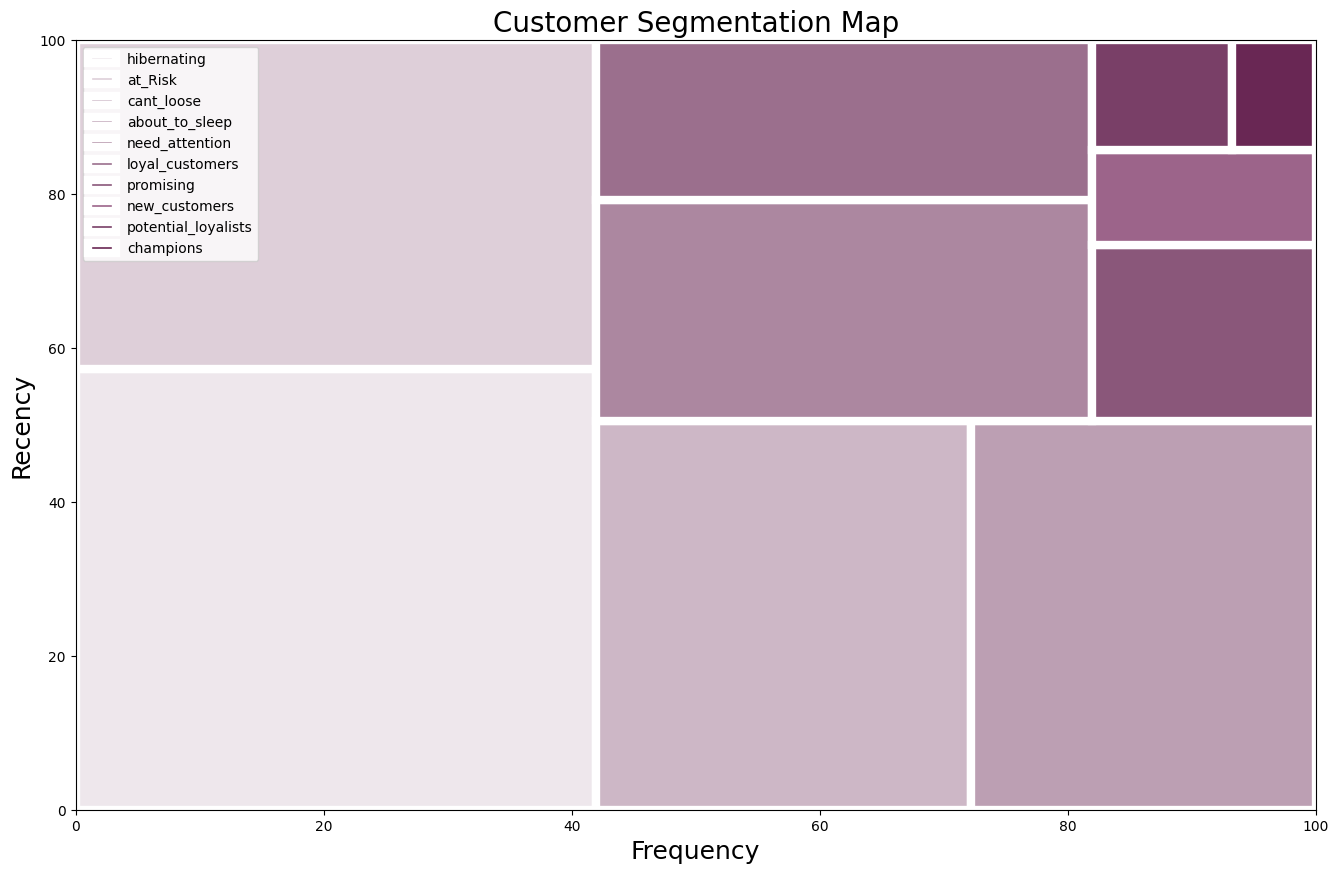

In [142]:
plt.figure(figsize=(15,10))
import squarify
segments = rfm["segment"].value_counts().sort_values(ascending=False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
labels=[label for label in seg_map.values()]
squarify.plot(
    sizes=segments,
    edgecolor="white", linewidth=6,
    color=[
        "#EEE7EC",
        "#DECFD9",
        "#CDB7C6",
        "#BC9FB3",
        "#AC87A0",
        "#9B6F8D",
        "#8A577A",
        "#9C648A",
        "#793F67",
        "#692754",
    ],
    pad=False,
    bar_kwargs={"alpha": 1},
    text_kwargs={"fontsize": 15},
)
 
plt.legend(handles=ax.containers[0], labels=labels,fontsize="10")

plt.title("Customer Segmentation Map", fontsize=20)
plt.xlabel("Frequency", fontsize=18)
plt.ylabel("Recency", fontsize=18)




**This map gives us the number of customers under a given segment and shows us the Frequency and Recency values for that segment. Hence, The customers which lie to the top right are the ones which have made most purchases and most recently made those purchases, meanwhile the ones at the bottom have made the lowest number of purchases and they made it a while ago.**

**Higher the recency, the lesser number of days since the last purchase.
The higher the Frequency, the more number of total purchases**

## Task 3 : Machine Learning Model for Customer Recommender

In [14]:
data_main

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


In [198]:
cleaned_desc.isnull().sum()

InvoiceNo           0
StockCode           0
Description         0
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     132905
Country             0
dtype: int64

Since the Customer ID is requiered for furthur processing , we need to drop all those which are null.

In [199]:
df_r = cleaned_desc.dropna()
df_r.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

We also know that some orderes were cancelled and we need to remove these too.

In [135]:
df_r.drop(df_r[df_r['StockCode'].str.endswith('C')].index)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


From the remainder of the dataset, we only need the UserId and StockCode. Also since the model we are applying is computationally intensive, we will have to cut the datatset and only provide a Proof of Concept, To do so , we will sort the data based on customers and pick the first 20,000 data points. 

In [136]:
df_r = df_r[['CustomerID','StockCode','Quantity']]

In [137]:
df_r.sort_values(by=['CustomerID'])
df_r.drop(df_r[df_r['Quantity']<1].index)
df_work = df_r.head(20000)

,CustomerID,StockCode,Quantity
61624,12346.0,23166,-74215
61619,12346.0,23166,74215
428984,12347.0,22621,12
428983,12347.0,22492,36
428982,12347.0,22561,12
...,...,...,...
392721,18287.0,22600,24
392737,18287.0,23269,36
392720,18287.0,22603,24
198718,18287.0,22753,12


In [140]:
len(df_work['CustomerID'].unique())

766

In [141]:
len(df_work['StockCode'].unique())

2230

We will now be working with data for 756 customers and 2226 products that they have purchased.

In [142]:
df2 = df_work.pivot_table(index = ['CustomerID', 'StockCode','Quantity'], aggfunc ='size')

df2 has the Quantity of a Stock purchased by a customer. Now we need to transform this data to a dataframe. 

In [143]:
df2=df2.to_frame()
final_dict = df2.to_dict()[0]

cust = []
code = []
quantity=[]
final_qty=[]

for i in list(final_dict.keys()):
    cust.append(i[0])
    code.append(i[1])
    quantity.append(i[2])
final_qty = list(final_dict.values())

for i in range (0,len(final_qty)):
    final_qty[i] = final_qty[i] * quantity[i]
    
    df_recommend = pd.DataFrame(list(zip(cust, code,final_qty)),
               columns =['CustomerId', 'StockCode','Qty'])

This is the final Dataframe that we will be applying our support vector decomposition on. 

In [150]:
ratings_utility_matrix = df_recommend.pivot_table(values='Qty', index='CustomerId', columns='StockCode', fill_value=0)
ratings_utility_matrix.head()

StockCode,10002,10120,10123C,10124A,10124G,10125,10133,10135,11001,15034,...,90212B,90212C,90214B,90214C,90214J,90214K,90214M,90214S,90214V,BANK CHARGES
CustomerId,,,,,,,,,,,,,,,,,,,,,
12347.0,0,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0
12370.0,0,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0
12386.0,0,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0
12395.0,0,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0
12427.0,0,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0,0,0.0,0,0


This is our Matrix wherein the X axis has the Product Code and the Y Axis has the detail of the customer. 
The intersection has the Quantity said customer has purchsed of said product. 

In [151]:
X = ratings_utility_matrix.T
X.head()
X1 = X

In [152]:
SVD = TruncatedSVD(n_components=10)
decomposed_matrix = SVD.fit_transform(X)
decomposed_matrix.shape

(2230, 10)

Here is where we reduce the above matrix into a matrix having only 10 columns without losing any data. 
Now, we will find the correlation of each product with every other product. 
For a given product P , the 10 most hihgly correlated products are the ones the customer is most likely to buy based on the Support Vector Decompositon.
We have shown an example of this in the code below.

In [153]:
correlation_matrix = np.corrcoef(decomposed_matrix)
product_names = list(X.index)
product_ID = product_names.index(testdata)
correlation_product_ID = correlation_matrix[product_ID]

recommended_products = list(X.index[correlation_product_ID > 0.90])
recommended_products.remove(testdata) 

print(data_main.loc[data_main['StockCode'] == testdata]['Description'].unique()[0])

print("")

for i in recommended_products[0:9]:
    print(data_main.loc[data_main['StockCode'] == i]['Description'].unique()[0])

(2230, 2230)

In [196]:
def findRecommendText(testdata):
    product_names = list(X.index)
    product_ID = product_names.index(testdata)
    correlation_product_ID = correlation_matrix[product_ID]
    recommended_products = list(X.index[correlation_product_ID > 0.90])
    recommended_products.remove(testdata) 
    print("The product previously purchased is " + data_main.loc[data_main['StockCode'] == testdata]['Description'].unique()[0])
    print("")
    print("The user is most likely to purchase the following :-")
    print("")
    for i in recommended_products[0:9]:
        print(data_main.loc[data_main['StockCode'] == i]['Description'].unique()[0])
        
    return recommended_products[0:9]
    

In [197]:
def findRecommend(testdata):
    product_names = list(X.index)
    product_ID = product_names.index(testdata)
    correlation_product_ID = correlation_matrix[product_ID]
    recommended_products = list(X.index[correlation_product_ID > 0.90])
    recommended_products.remove(testdata) 
        
    return recommended_products[0:9]
    

In [193]:
correct_class =0
wrong = 0
for i in X.index:
    recommendation = findRecommend(i)
    
    product_pool = []
    
    for j in (cleaned_desc.loc[cleaned_desc['StockCode'] == i]['CustomerID']):
        test=list(cleaned_desc.loc[cleaned_desc['CustomerID'] == j]['StockCode'])
        product_pool.extend(test)
        
    for k in recommendation:
        if (k in list(test)):
            correct_class = correct_class +1
            break
    else:
        wrong = wrong +1
    


In [194]:
correct_class

524

In [195]:
 wrong 

1706

#### How the tester works : 
For every produdct in our dataframe(Say p), we pass it to the recommender.
The Recommender returns a list of 10 most likely products. 
Then, we take this product p and find every customer that has purcahsed this p. 
Then, we find every product purchased by every customer that has purchased p, This creates the product_pool. 
If even one of the recommendations are present in the product pool for product p , we classify it as a correct recommendation, else its a wrong recommendation. 